In [ ]:
# install.packages("data.table")
## install.packages("ggplot2")
library(data.table)
library(ggplot2)
library(car)
library(plotly)

library (MASS)
library(mixtools)


Proyecto: Estimación de la densidad del aire

Integrantes:

Wagner Bermúdez Ordóñez

Johnny Borbón Valverde

Valeria Bonilla Rojas

Daniel Espinoza Castro

Jose Ortega Bonilla

Ever Ortega Calderón

Anthonny Seas Hidalgo

En este cuaderno de R se busca implementar una estimación de la densidad del aire con su incertidumbre en el laboratorio de balanzas del DMQ del LCM. Para esto se cuentan con datos de cuatro años de las condiciones ambientales del laboratorio.

La densidad del aire se estimó por medio de la fórmula CIPM-2007 que se encuentra en el artículo Revised formula for the density of moist air (CIPM-2007) de A Picard, R S Davis, M Gläser y K Fujii del 200820082008, este se puede visitar en https://www.nist.gov/system/files/documents/calibrations/CIPM-2007.pdf.

A su vez se utilizó la una constante de los gases ideales más actualizada del sitio https://physics.nist.gov/cuu/Constants/index.html, pues es el valor más actualizado de acuerdo a las definiciones nuevas de las magnitudes.

# Corrección en los datos

Entre el set de datos brindados, se presenta la anomalía en la cual ciertos días tienen como unidad de temperatura ?C, mientras que otros poseen la unidad °C. A su vez el lenguaje R, presenta dificultades al manejar el símbolo de grados "°". 

Por lo que se adjunta el siguiente código en Python para el reemplazo del símbolo "°" por "?" en todos los archivos .log. 

Cabe destacar que se debe ingresar la ruta de acceso de cada una de las 4 carpetas que contiene los datos, en este caso las carpetas 2019, 2020, 2021 y 2022. 

In [ ]:
#Librería encargada de ejecutar código de Python en R.
library(reticulate) #Verificar que se cuente con la librería instalada

# Establece la ruta del directorio
dir_path <- "C:/Users/UsuarioA/Datos/CondicionesAmbientalesBalanzas/2019"

# Importa el módulo os de Python
os <- import("os")

# Recorre todos los archivos con extensión .LOG en el directorio
for (filename in os$listdir(dir_path)) {
  if (endsWith(filename, ".LOG")) {
    filepath <- file.path(dir_path, filename)
    
    # Abre el archivo y lee todo el contenido
    content <- readLines(filepath, encoding = "latin1")
    
    # Reemplaza el carácter "°" por "?"
    content <- gsub("°", "?", content, fixed = TRUE)
    
    # Escribe el contenido modificado en el mismo archivo
    con <- file(filepath, "w", encoding = "latin1")
    writeLines(content, con)
    close(con)
  }
}

# Carga de datos

Para la carga de datos se debe definir la ruta de acceso de la carpeta que contiene los 4 años de datos en diferentes carpetas. El código genera una lista única que cuenta con los casi un millón de datos a analizar.


In [ ]:
# Establecer el directorio de trabajo en el directorio principal
setwd("C:/Users/UsuarioA/Datos/CondicionesAmbientalesBalanzas")

# Obtener la lista de todos los archivos en las cuatro carpetas
archivos <- list.files(path = ".", pattern = "*", recursive = TRUE, full.names = TRUE)

# Se genera una matriz de 0 Filas y 13 columnas en la cual se almacenan todos los datos.
datos_totales <- data.frame(matrix(nrow = 0, ncol = 13))

# Se nombran las columnas de la matriz
colnames(datos_totales) <- c("Día", "Hora", "Temperatura", "Unidad Temp", "Humedad Relativa", "Unidad HR", "Presión", "Unidad Presión", "Densidad", "Unidad Densidad", "0", "chk", "Valor")

# Se genera un bucle for en el cual se itera sobre cada archivo de cada carpeta
for (archivo in archivos) {
  # Lee el archivo y se ingresan los valores en una nueva matriz
  datos <- read.table(archivo, header = FALSE, sep= "")

  # Se nombran las columnas de la nueva matriz
  colnames(datos) <- c("Día", "Hora", "Temperatura", "Unidad Temp", "Humedad Relativa", "Unidad HR", "Presión", "Unidad Presión", "Densidad", "Unidad Densidad", "0", "chk", "Valor")
  
  # Se ingresan los datos leidos a la matriz con todos los datos almacenados.
  datos_totales <- rbind(datos_totales, datos)
}



# Análisis exploratorio de las magnitudes de interés


Se realiza un análisis exploratorio de las magnitudes de interés: temperatura ambiental, presión atmosférica y humedad relativa. Para esto:

* Se realiza una discriminación de datos diurnos (8 am a 4 pm) y nocturnos para que el estudio sea más completo.
* Se descartan los datos atípicos.
* Se analizan las tendencias, si las hubiera, en las magnitudes de influencia.


In [ ]:
#Se procede con la discriminación de datos diurnos (8 am a 4 pm) y nocturnos para que el estudio sea más completo

#Datos dirnunos
Hora_dia <- c()
Temperatura_dia <- c()
HumedadRelativa_dia <- c()
Presion_dia <- c()

#Datos nocturnos
Hora_noche <- c()
Temperatura_noche <- c()
HumedadRelativa_noche <- c()
Presion_noche <- c()

#Al correr el código con todos los datos, el ciclo for puede presentar un error, sin embargo, aún así el código funciona y realiza su función
for (i in 1:dim(datos_totales[2])[1]){

  if (strtoi(unlist(strsplit(datos_totales$Hora[i], ":"))[1])>7 & strtoi(unlist(strsplit(datos_totales$Hora[i], ":"))[1])<17){
    
    Hora_dia = c(Hora_dia,datos_totales$Hora[i])

    Temperatura_dia = c(Temperatura_dia,datos_totales$Temperatura[i])

    HumedadRelativa_dia = c(HumedadRelativa_dia,datos_totales$`Humedad Relativa`[i])

    Presion_dia = c(Presion_dia, datos_totales$Presión[i])
  }

  else{
    
    Hora_noche = c(Hora_noche,datos_totales$Hora[i])

    Temperatura_noche = c(Temperatura_noche,datos_totales$Temperatura[i])

    HumedadRelativa_noche = c(HumedadRelativa_noche,datos_totales$`Humedad Relativa`[i])

    Presion_noche = c(Presion_noche, datos_totales$Presión[i])
    
  }
}

datos_totales_dia <- data.frame(Hora_dia, Temperatura_dia,HumedadRelativa_dia,Presion_dia)

colnames(datos_totales_dia) <- c("Hora", "Temperatura", "Humedad Relativa", "Presión")

datos_totales_noche <- data.frame(Hora_noche, Temperatura_noche,HumedadRelativa_noche,Presion_noche)

colnames(datos_totales_noche) <- c("Hora", "Temperatura", "Humedad Relativa", "Presión")

#Ahora se inicia con el proceso de detección y eliminación de datos atipicos para los datos diurnos

#Se obtienen los valores estaditicos para el diagrama de cajas de la temperatura
boxplotstats_temp <- boxplot.stats(datos_totales_dia$Temperatura, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_temp <- boxplotstats_temp$stats[5]

min_temp <- boxplotstats_temp$stats[1]

#Se obtienen los valores estaditicos para el diagrama de cajas de la humedad relativa
boxplotstats_hr <- boxplot.stats(datos_totales_dia$`Humedad Relativa`, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_hr <- boxplotstats_hr$stats[5]

min_hr <- boxplotstats_hr$stats[1]

#Se obtienen los valores estaditicos para el diagrama de cajas de la presión
boxplotstats_pr <- boxplot.stats(datos_totales_dia$Presión, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_pr <- boxplotstats_pr$stats[5]

min_pr <- boxplotstats_pr$stats[1]

#Se crea un nuevo set de vectores para almacenar los datos diurnos sin los datos atipicos
Hora_dia_limpio <- c()
Temperatura_dia_limpio <- c()
HumedadRelativa_dia_limpio <- c()
Presion_dia_limpio <- c()


for (j in 1:length(datos_totales_dia$Temperatura)){
  if (max_temp >= datos_totales_dia$Temperatura[j]){
    if (min_temp <= datos_totales_dia$Temperatura[j]){
      if (max_hr >= datos_totales_dia$`Humedad Relativa`[j]){
        if (min_hr <= datos_totales_dia$`Humedad Relativa`[j]){
          if (max_pr >= datos_totales_dia$`Presión`[j]){
            if (min_pr <= datos_totales_dia$`Presión`[j]){
              Hora_dia_limpio <- c(Hora_dia_limpio,datos_totales_dia$Hora[j])
              Temperatura_dia_limpio <- c(Temperatura_dia_limpio,datos_totales_dia$Temperatura[j])
              HumedadRelativa_dia_limpio <- c(HumedadRelativa_dia_limpio,datos_totales_dia$`Humedad Relativa`[j])
              Presion_dia_limpio <- c(Presion_dia_limpio,datos_totales_dia$Presión[j])
            }
          }
        }
      }
    }
  }
}

#Se crea un nuevo dataframe ya con los datos totales diurnos sin los datos atipicos
datos_totales_dia_limpio <- data.frame(Hora_dia_limpio, Temperatura_dia_limpio,HumedadRelativa_dia_limpio,Presion_dia_limpio)

colnames(datos_totales_dia_limpio) <- c("Hora", "Temperatura", "Humedad Relativa", "Presión")


#Se realizan los Diagrmas de Cajas para cada una de las variables de entrada
boxplot(datos_totales_dia_limpio$Temperatura, ylab= "Temperatura (°C)", main= "Diagrama de cajas para la Temperatura en datos diurnos")
boxplot(datos_totales_dia_limpio$`Humedad Relativa`, ylab= "Humedad relativa (%)", main= "Diagrama de cajas para la Humedad Relativa en datos diurnos")
boxplot(datos_totales_dia_limpio$Presión, ylab= "Presión (hPa)", main= "Diagrama de cajas para la Presión en datos diurnos")


#Además se realizan los gráficos de pruebas de normalidad para cada una de las variables de entrada
qqPlot(datos_totales_dia_limpio$Temperatura, main= "Gráfico de normalidad para la temperatura en datos diurnos", xlab="Datos", ylab= "Temperatura (°C)")
qqPlot(datos_totales_dia_limpio$`Humedad Relativa`, main= "Gráfico de normalidad para la humedad relativa en datos diurnos", xlab="Datos", ylab= "Humedad relativa (%)")
qqPlot(datos_totales_dia_limpio$Presión, main= "Gráfico de normalidad para la presión en datos diurnos", xlab="Datos", ylab= "Presión (hPa)")


#Realizando los histogramas para cada variable de entrada para los datos diurnos, para esto se utiliza un ancho de banda para cada variable:

bw_temp <- (max_temp - min_temp)/(3.332*log10(length(Temperatura_dia_limpio)))
bw_hum <- (max_hr - min_hr)/(3.332*log10(length(HumedadRelativa_dia_limpio)))
bw_pres <- (max_pr - min_pr)/(3.332*log10(length(Presion_dia_limpio)))


hist(datos_totales_dia_limpio$Temperatura, main="Histograma de la temperatura para datos diurnos",
     density=20, prob=T, xlab="Temperatura (°C)", ylab="Densidad de probabilidad")
  lines(density(datos_totales_dia_limpio$Temperatura, bw=bw_temp), col="blue", lwd=2)
  

hist(datos_totales_dia_limpio$`Humedad Relativa`, main="Histograma de la humedad relativa para datos diurnos",
     density=20, prob=T, xlab="Humedad relativa (%)", ylab="Densidad de probabilidad")
  lines(density(datos_totales_dia_limpio$`Humedad Relativa`, bw=bw_hum), col="blue", lwd=2)


hist(datos_totales_dia_limpio$Presión, main="Histograma de la Presión para datos diurnos",
     density=20, prob=T, xlab="Presión (hPa)", ylab="Densidad de probabilidad")
  lines(density(datos_totales_dia_limpio$Presión, bw=bw_pres), col="blue", lwd=2)



#Ahora se inicia con el proceso de detección y eliminicación de datos atipicos para los datos nocturnos

#Se obtienen los valores estaditicos para el diagrama de cajas de la temperatura
boxplotstats_temp_noche <- boxplot.stats(datos_totales_noche$Temperatura, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_temp_noche <- boxplotstats_temp_noche$stats[5]

min_temp_noche <- boxplotstats_temp_noche$stats[1]

#Se obtienen los valores estaditicos para el diagrama de cajas de la humedad relativa
boxplotstats_hr_noche <- boxplot.stats(datos_totales_noche$`Humedad Relativa`, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_hr_noche <- boxplotstats_hr_noche$stats[5]

min_hr_noche <- boxplotstats_hr_noche$stats[1]

#Se obtienen los valores estaditicos para el diagrama de cajas de la presión
boxplotstats_pr_noche <- boxplot.stats(datos_totales_noche$Presión, coef = 0.65, do.conf = TRUE, do.out = TRUE)

max_pr_noche <- boxplotstats_pr_noche$stats[5]

min_pr_noche <- boxplotstats_pr_noche$stats[1]

#Se crea un nuevo set de vectores para almacenar los datos diurnos sin los datos atipicos
Hora_noche_limpio <- c()
Temperatura_noche_limpio <- c()
HumedadRelativa_noche_limpio <- c()
Presion_noche_limpio <- c()


for (j in 1:length(datos_totales_noche$Temperatura)){
  if (max_temp_noche >= datos_totales_noche$Temperatura[j]){
    if (min_temp_noche <= datos_totales_noche$Temperatura[j]){
      if (max_hr_noche >= datos_totales_noche$`Humedad Relativa`[j]){
        if (min_hr_noche <= datos_totales_noche$`Humedad Relativa`[j]){
          if (max_pr_noche >= datos_totales_noche$`Presión`[j]){
            if (min_pr_noche <= datos_totales_noche$`Presión`[j]){
              Hora_noche_limpio <- c(Hora_noche_limpio,datos_totales_noche$Hora[j])
              Temperatura_noche_limpio <- c(Temperatura_noche_limpio,datos_totales_noche$Temperatura[j])
              HumedadRelativa_noche_limpio <- c(HumedadRelativa_noche_limpio,datos_totales_noche$`Humedad Relativa`[j])
              Presion_noche_limpio <- c(Presion_noche_limpio,datos_totales_noche$Presión[j])
            }
          }
        }
      }
    }
  }
}

#Se crea un nuevo dataframe ya con los datos totales noctunos sin los datos atipicos
datos_totales_noche_limpio <- data.frame(Hora_noche_limpio, Temperatura_noche_limpio,HumedadRelativa_noche_limpio,Presion_noche_limpio)

colnames(datos_totales_noche_limpio) <- c("Hora", "Temperatura", "Humedad Relativa", "Presión")
  

  
#Se realizan los Diagramas de Cajas para cada una de las variables de entrada:
boxplot(datos_totales_noche_limpio$Temperatura, ylab= "Temperatura (°C)", main= "Diagrama de cajas para la temperatura en datos nocturnos")
boxplot(datos_totales_noche_limpio$`Humedad Relativa`, ylab= "Humedad relativa (%)",  main= "Diagrama de cajas para la humedad relativa en datos nocturnos")
boxplot(datos_totales_noche_limpio$Presión, ylab= "Presión (hPa)",  main= "Diagrama de cajas para la presión en datos nocturnos")


#Además se realizan los gráficos de pruebas de normalidad para cada una de las variables de entrada:
qqPlot(datos_totales_noche_limpio$Temperatura, main= "Gráfico de normalidad para la temperatura en datos nocturnos", xlab="Datos", ylab= "Temperatura (°C)")
qqPlot(datos_totales_noche_limpio$`Humedad Relativa`, main= "Gráfico de normalidad para la humedad relativa en datos nocturnos", xlab="Datos", ylab= "Humedad relativa (%)")
qqPlot(datos_totales_noche_limpio$Presión, main= "Gráfico de normalidad para la presión en datos nocturnos", xlab="Datos", ylab= "Presión (hPa)")

#Realizando los histogramas para cada variable de entrada para los datos nocturnos:

bw_temp <- (max_temp - min_temp)/(3.332*log10(length(Temperatura_noche_limpio)))
bw_hum <- (max_hr - min_hr)/(3.332*log10(length(HumedadRelativa_noche_limpio)))
bw_pres <- (max_pr - min_pr)/(3.332*log10(length(Presion_noche_limpio)))


hist(datos_totales_noche_limpio$Temperatura, main="Histograma de la temperatura para datos nocturnos",
     density=20, prob=T, xlab="Temperatura (°C)", ylab="Densidad de probabilidad")
lines(density(datos_totales_noche_limpio$Temperatura, bw=bw_temp), col="blue", lwd=2)


hist(datos_totales_noche_limpio$`Humedad Relativa`, main="Histograma de la humedad relativa para datos nocturnos",
     density=20, prob=T, xlab="Humedad relativa (%)", ylab="Densidad de probabilidad")
lines(density(datos_totales_noche_limpio$`Humedad Relativa`, bw=bw_hum), col="blue", lwd=2)


hist(datos_totales_noche_limpio$Presión, main="Histograma de la Presión para datos nocturnos",
     density=20, prob=T, xlab="Presión (hPa)", ylab="Densidad de probabilidad")
lines(density(datos_totales_noche_limpio$Presión, bw=bw_pres), col="blue", lwd=2)





Entre los resultados obtenidos para los datos diurnos de la presión se obtiene:

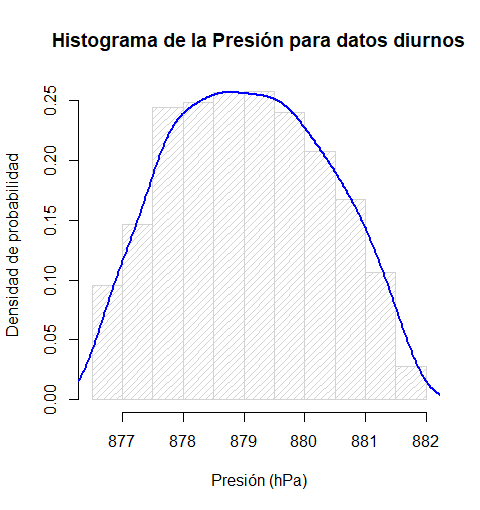

En el histograma anterior, referente a la distribución de probabilidad de la presión atmosférica, donde se puede observar que la tendencia es muy parecida a una normal, debido a su similitud con la campana de Gauss, en esta se muestra la acumulación de los datos muy cercanos a un valor de la moda, 879 hPa.

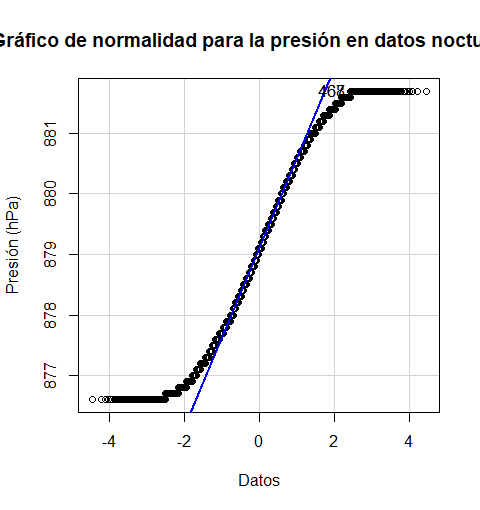

En el grafico de normalidad mostrado anteriormente, se pueden notar datos que no se apegan del todo a la recta, estos son datos atípicos no considerados como tales en la prueba realizada, pueden darse debido a la gran cantidad de datos analizados.

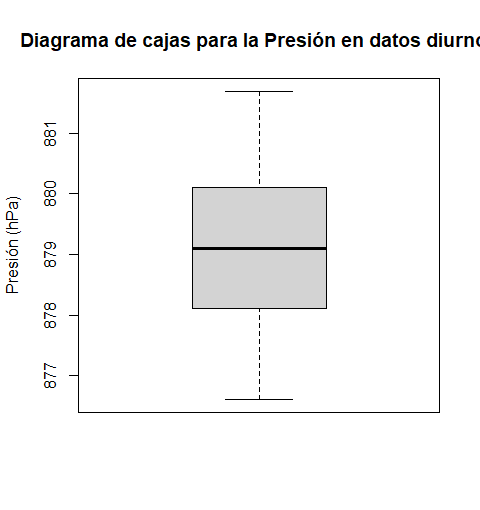

Por parte del diagrama de caja respectivo a la presión, se puede notar que este no muestra datos atípicos, esto puede darse debido a que, en la prueba para considerar datos atípicos, se utilizó diagramas de cajas. Además, así como en el histograma, se puede observar que la mediana y la posible media, rondan los 879 hPa.

Por su parte, los resultados de la temperatura de los datos diurnos son:

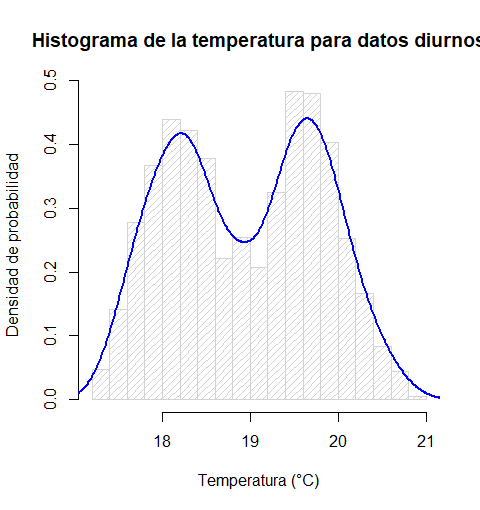

En el histograma respectivo a la temperatura para los datos diurnos, se puede observar una tendencia bimodal, donde los datos se acumulan más en valores cercanos a 18 °C y 20 °C.

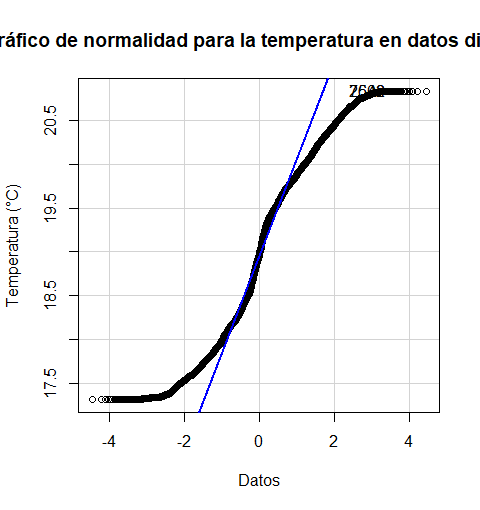

En el gráfico de normalidad para la temperatura para datos durante el día, se puede observar que sí se apegan a la recta, sin embargo, hay datos que se alejan, más que todo a los extremos del gráfico, esto se acopla muy bien con el histograma, demostrando que los datos no son del todo normales.

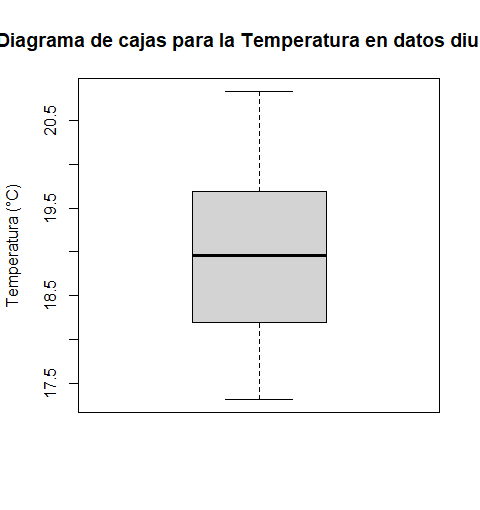

Por parte del diagrama de cajas para la temperatura en os datos diurnos, se puede observar que tampoco se muestras datos atípicos y que su media ronda el valor de 19 °C.

Finalmente, los resultados para la humedad relativa de los datos diurnos son:

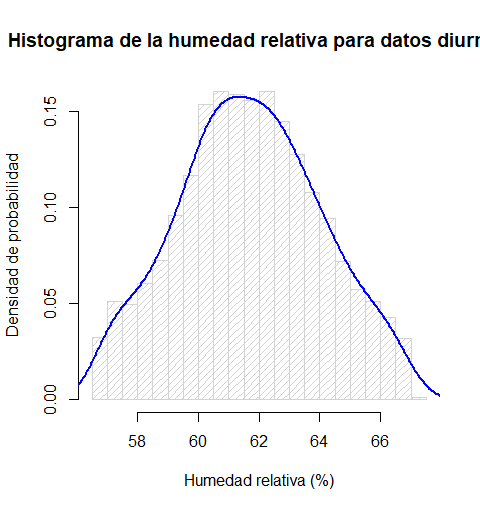

El histograma referente a la humedad relativa para los datos diurnos muestra una tendencia casi normal, esto donde se observa una tendencia a un valor cercano a 62 % de humedad relativa. 

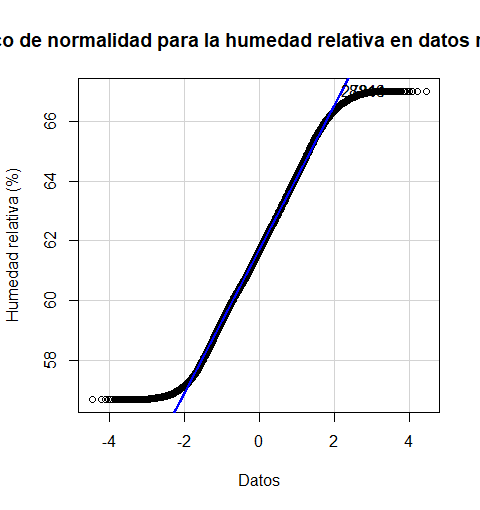

Por parte del gráfico de normalidad para la humedad relativa, se observa la tendencia muy cercana a la recta, demostrando que efectivamente los datos se distribuyen normalmente.

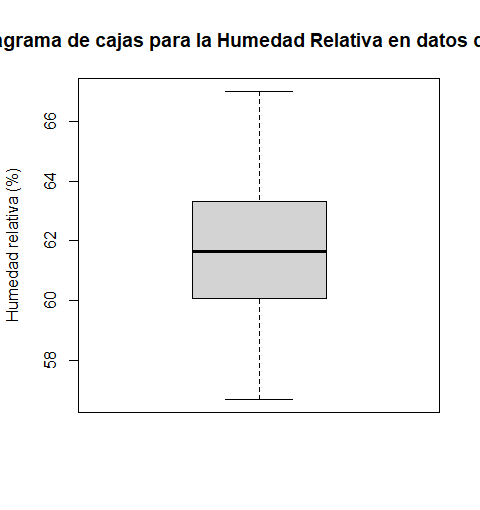

Por parte del diagrama de caja, para la humedad relativa, tampoco se observan datos atípicos y además, que la mediana se aproxima a un valor de 62 %.

Para el caso de los datos nocturnos, los resultados de la presión son:

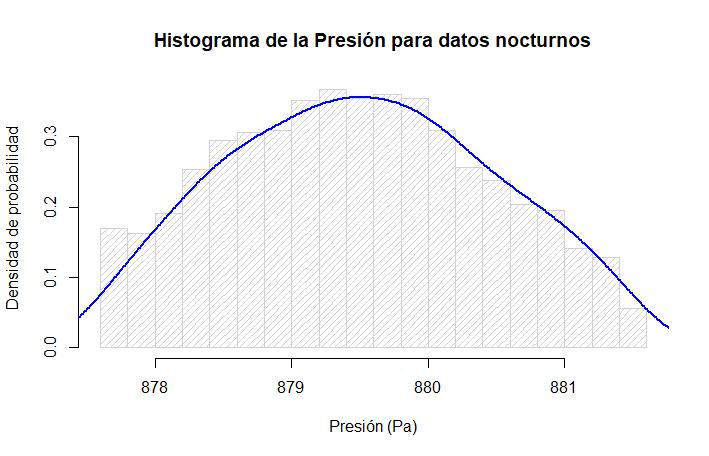

En el histograma anterior, referente a la distribución de probabilidad de la presión atmosférica para datos nocturnos, donde se puede observar que la tendencia es muy parecida a una normal, en esta se muestra la acumulación de los datos muy cercanos a un valor de 879,5 hPa.

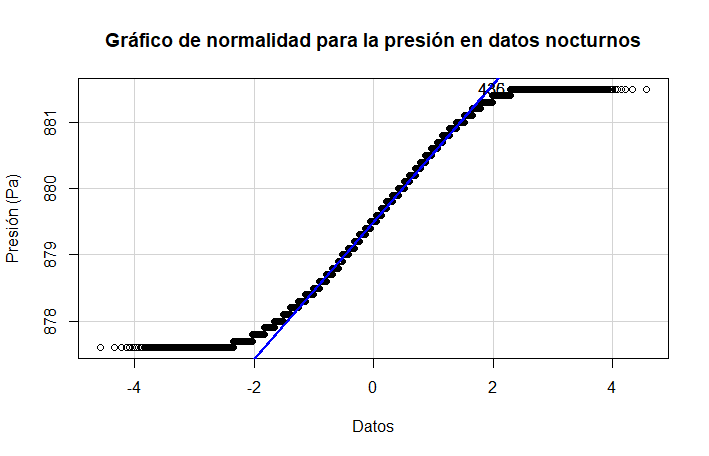

En el grafico de normalidad mostrado anteriormente, se pueden notar datos que no se apegan del todo a la recta en los extremos, estos son datos atípicos no considerados como tales en la prueba realizada, debido a la gran cantidad de datos analizados, además esto demuestra la normalidad de los datos.

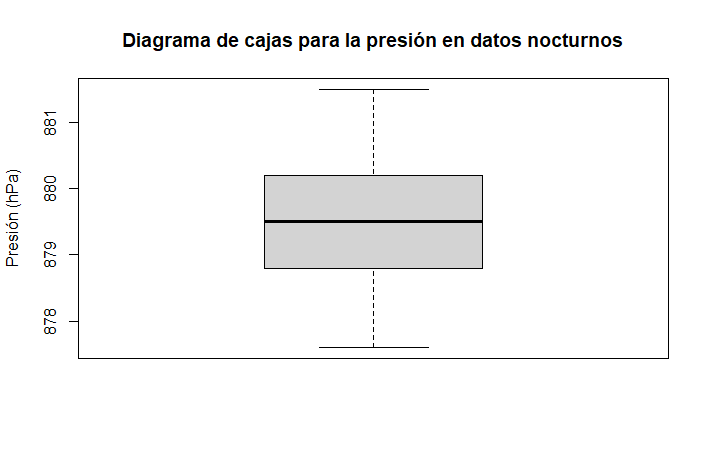

Por parte del diagrama de caja respectivo a la presión, se puede notar que este no muestra datos atípicos, esto puede darse debido a que, esto al utilizar diagrama de cajas como prueba de datos atípicos. Además, así como en el histograma, se puede observar que la mediana y la posible media, rondan los 879,5 hPa.

En el caso de los datos nocturnos de la temperatura, se tiene que:

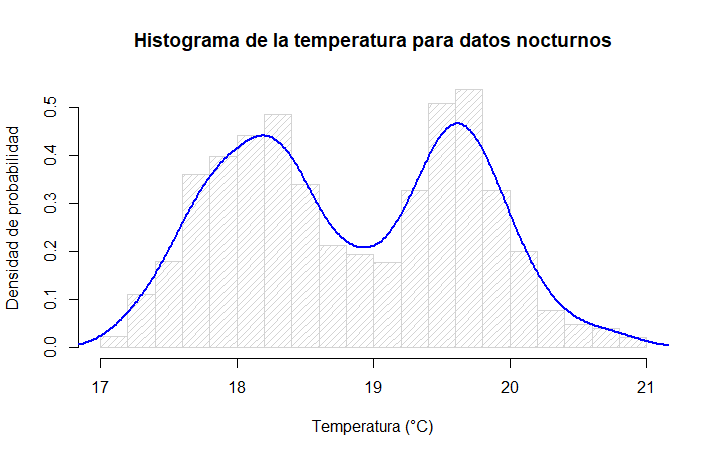

En el histograma respectivo a la temperatura para los datos nocturnos, se puede observar una tendencia bimodal, donde los datos se acumulan más en valores cercanos a 18 °C y 20 °C.

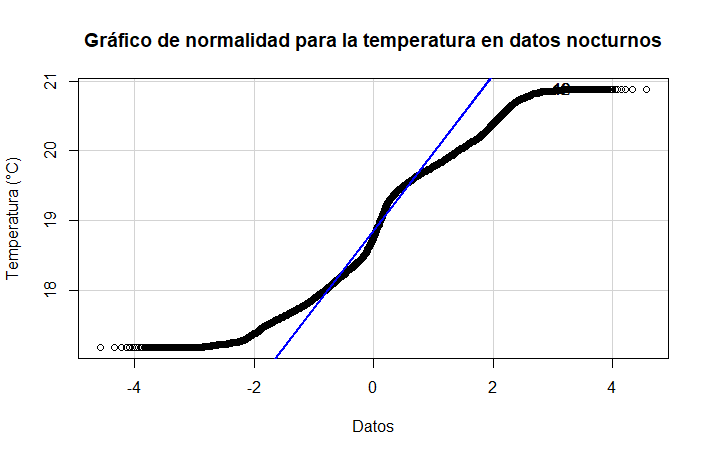

En el gráfico de normalidad para la temperatura para datos durante la noche, se puede observar que sí se apegan a la recta, sin embargo, hay datos que se alejan, más que todo a los extremos del gráfico, esto se acopla muy bien con el histograma, demostrando que los datos no son del todo normales.

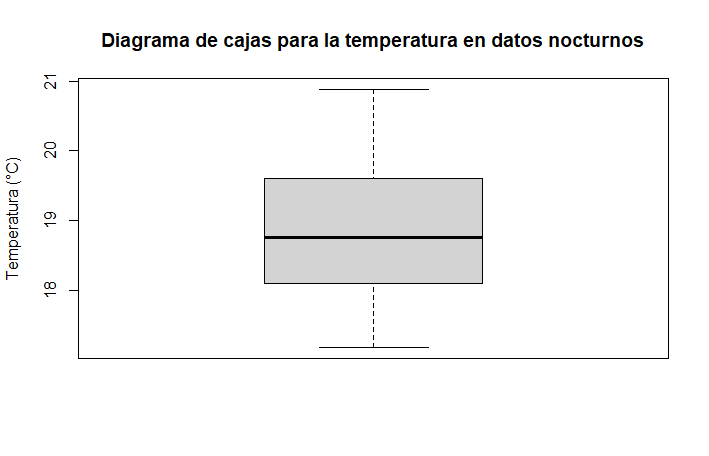

Por parte del diagrama de cajas para la temperatura en os datos nocturnos, se puede observar que tampoco se muestras datos atípicos y que su media ronda el valor de 18,5 °C.

Finalmente, los resultados de la humedad relativa para los datos nocturnos son:

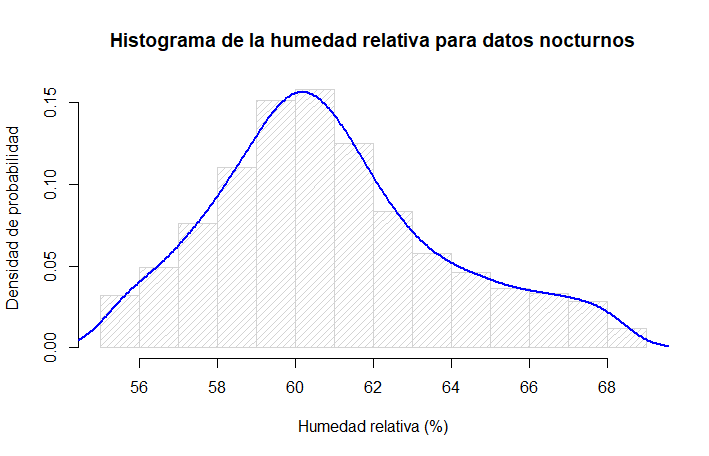

El histograma referente a la humedad relativa para los datos nocturnos muestra una tendencia casi normal, esto donde se observa una tendencia a un valor cercano a 60 % de humedad relativa. 

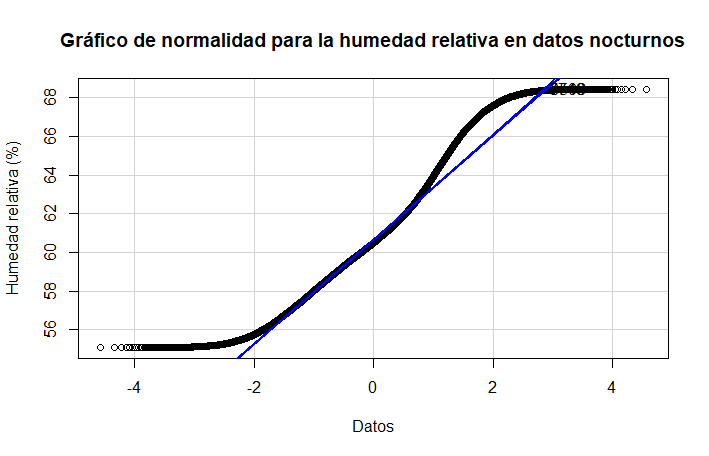

Por parte del gráfico de normalidad para la humedad relativa, se observa la tendencia muy cercana a la recta, solamente alejándose en el extremo superior, demostrando que efectivamente los datos se distribuyen aproximadamente de manera normal.

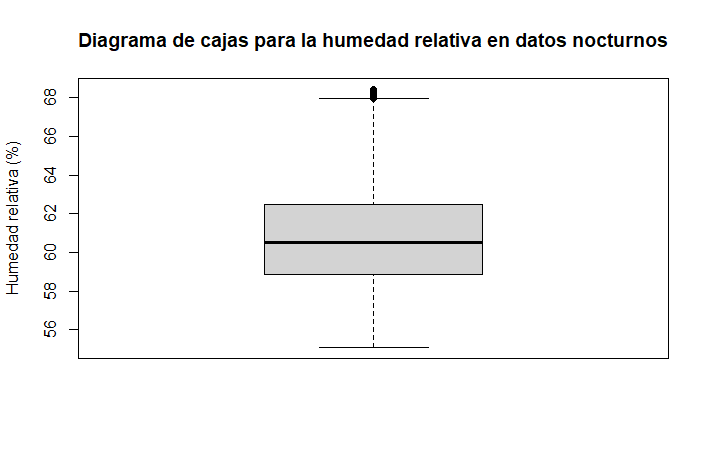

Por parte del diagrama de caja, para la humedad relativa para los datos de la noche, se observan pocos datos atípicos, que están fuera de los cuartiles, sin embargo, no están alejados del mismo, estos pueden explicar que la tendencia no sea del todo normal en estos datos.

# Funciones para el cálculo de la densidad del aire


Como se menciona con anterioridad para calcular la densidad del aire ($\rho$) se utilizó la fórmula del CIPM 2007, la cual se define como:

$$
ρ=\frac{pM_a}{ZRT}\left[1-x_ν\left(1-\frac{M_v}{M_a}\right)\right] 
$$

En donde:

$p$: Es la presión y está medida en pascales [Pa]

$M_a$: Es la masa molar del aire seco [kg/mol]

$Z$: Es el factor de compresibilidad y es adimensional.

$R$: Es la constante de los gases ideales [J/(mol K)]

$T$: Es la temperatura medida en kelvin [K]

$x_ν$: Es la fracción molar del vapor de agua y es adimensional.

$M_v$: Es la masa molar del agua [kg/mol]

Primeramente, es necesario realizar el cálculo de la presión de vapor saturado ($p_{sv}$), el cual se define como:

$$
p_{sv}=1 [Pa] \cdot e^{AT^2+BT+C+D/T}
$$

Donde:

$A$ = 1.237 884 7 $\times 10^{-5}$ K$^{-2}$

$B$ = -1.912 131 6 $\times 10^{-2}$ K$^{-1}$

$C$ = 33.937 110 47

$D$ = -6.343 164 5  $\times 10^{3}$ K

Dicha presión se calcula en el siguiente código.



In [ ]:
Psv=function(t){ #LA TEMPERATURA VA EN KELVIN
  # Función que calcula la presión de vapor de saturación siguiendo la fórmula que se presenta en el artículo de referencia.
  
  #Input:
  #-------------
  #t: temperatura en °C.
  
  #Definición de constantes
  A=1.2378847*10**(-5) #K^-2
  B=-1.9121316*10**(-2) #K^-1
  C= 33.93711047 #sin unidades
  D= -6.3431645*10**3 #K
  
  #Output:
  #-------------
  #Psv: valor de la presión de vapor de saturación en hPa.
  
  T=t+273.15 #Se pasa de Celsius a Kelvin para poder usar las constantes
  
  Psv = 1*exp(A*T**2+B*T+C+D/T) 
  
  return(Psv)
}


Seguidamente, es necesario el cálculo del factor de mejora ($f$), el cual se define como:

$$
f=\alpha + \beta p + \gamma T^2
$$

Donde:

$\alpha$ = 1.000 62

$\beta$ = 3.14 $\times 10^{-8}$ Pa$^{-1}$

$\gamma$ = 5.6 $\times 10^{-7}$ K$^{-2}$

Este factor de mejor se obtiene en el siguiente código:


In [ ]:
f=function(t,P){
  # Función que calcula el factor de mejora siguiendo la ecuación de la referencia.
  
  # Input:
  # --------------
  # P: presión en Pa.
  # t: temperatura en °C.
  
  # Output:
  # --------------
  # f: Valor del coeficiente de mejora.
 
  alpha= 1.00062 #sin unidades
  beta= 3.14*10**(-8) #Pa^-1
  gamma= 5.6*10**(-7) #K^-2
  
  T=t+273.15
  
  f= alpha + beta*P + gamma*T**2
  
  return(f)
}

Para el cálculo de la fracción molar de vapor ($x_ν$) se tiene la siguiente relación:
$$ x_v=h\cdot f(T,P)\cdot \frac{(P_{sv}(T))}{(P\cdot 100)}$$

Donde:

$h =$ humedad relativa (valor entre 0 y 1)

Dicha fracción molar se calcula a través del siguiente código:


In [ ]:
xv=function(t,P,h){
  # Función que calcula la fracción molar de vapor de agua siguiendo el artículo de referencia.
  
  # Input:
  # ---------------
  # h: humedad relativa como un valor entre 0 y 1.*AVERIGUAR CUAL ES ESTE*
  # P: presión atmosférica en Pa.
  # t: Temperatura en °C.
  
  # Output:
  # ---------------
  # xv: Valor de la fracción molar de vapor de agua.
  
  xv= h*f(t,P)*(Psv(t)/(P))
  
  return(xv)
}

Finalmente, se debe realizar el cálculo del factor de compresibilidad ($Z$), el cual se define como:

$$
Z=1-\frac{p}{T}\cdot [a_0+a_1T+a_2T^2+(b_0+b_1T)x_v+(c_0+c_1T)x_v^2]+\frac{p^2}{T^2}\cdot (d+ex_\nu^2)
$$

Donde:

$a_0$ = 1.581 23 $\times10^{-6}$ K Pa$^{-1}$

$a_1$ = -2.9331 $\times10^{-8}$ Pa$^{-1}$

$a_2$ = 1.1043 $\times10^{-10}$ K$^{-1}$ Pa$^{-1}$

$b_0$ = 5.707 $\times10^{-6}$ K Pa$^{-1}$

$b_1$ = -2.051 $\times10^{-8}$ Pa$^{-1}$

$c_0$ = 1.9898 $\times10^{-4}$ K Pa$^{-1}$

$c_1$ = -2.376 $\times10^{-6}$ Pa$^{-1}$

$d$ = 1.83 $\times10^{-11}$ K$^2$ Pa$^{-2}$

$e$ = -0.765 $\times10^{-8}$ K$^2$ Pa$^{-2}$

Dicho factor de compresibilidad se calcula en el siguiente código.

In [ ]:
Z=function(t,P,h){
  # Función que calcula el factor de compresibilidad con la ecuación del artículo de referencia.
  
  # Input:
  # --------------
  # P: Presión atmosférica en Pa.
  # h: Humedad relativa como un valor entre 0 y 1.
  # t: Temperatura en °C.
  
  # Output:
  # ---------------
  # Z: factor de compresibilidad.
  # Defina las constantes
  a0= 1.58123*10**(-6) #K Pa^-1
  a1= -2.9331*10**(-8) #Pa^-1
  a2= 1.10432*10**(-10) #K^-1 Pa^-1
  b0= 5.707*10**(-6) #K Pa^-1
  b1= -2.051*10**(-8) #Pa^-1
  c0= 1.9898*10**(-4) #K Pa^-1
  c1= -2.376*10**(-6) #Pa^-1
  d= 1.82*10**(-11) #K^2 Pa^-2
  e= -0.765*10**(-8) #K^2 Pa^-2
  
  T=t+273.15
  
  Z = 1 - P/T*(a0+a1*T+a2*T**2+(b0+b1*T)*xv(t,P,h)+(c0+c1*T)*xv(t,P,h)**2) + (P**2)/(T**2)*(d+e*xv(t,P,h)**2) 
    
  return(Z)
}


Una vez obtenidas las variables se realiza el cálculo de la densidad del aire con base a la ecuación dada anteriormente.

In [ ]:
DensidadCIPM=function(t,P,h){
  # Función que calcula la densidad del aire a partir de la ecuación del artículo de referencia.
  
  # Input:
  # --------------
  # P: Presión atmosférica en Pa.
  # Hr: Humedad relativa como un valor entre 0 y 1.
  # T: Temperatura en °C.
  
  # Output:
  # --------------
  # DensidadCIPM: densidad del aire en kg/m^3.
  # Defina las constantes
  Ma= 28.96546*10**(-3) #kg mol^-1 
  Mv= 18.01527*10**(-3) #kg mol^-1
  R= 8.314472 #J*k*mol - SE USA ESTA PORQUE ES LA QUE USA EL PAPER Y EL LINK DE ALLAN NO SIRVE 
  
  T=t+273.15
  
  DensidadCIPM = (P*Ma)/(Z(t,P,h)*R*T)*(1-xv(t,P,h)*(1-(Mv/Ma)))
  
  return(DensidadCIPM)
}

Seguidamente, se realiza el cálculo de densidad del aire para el día y para la noche.

In [ ]:
# Calcule las densidades.

#Densidades de día
densidad_dia<- c()
for (i in 1:length(datos_totales_dia_limpio$Temperatura)){ #Se pone temperatura como genérico, se puede poner cualquier columna ya que toda tienen el mismo largo y la idea es que recorra todos los valores
  t<- datos_totales_dia_limpio$Temperatura[i]
  h<- datos_totales_dia_limpio$`Humedad Relativa`[i]/100 #Se trabaja entre 0 y 1
  P<- datos_totales_dia_limpio$`Presión`[i]*100 #Los datos vienen en hPa y las formulas trabajan en Pa
  densidad<- DensidadCIPM(t,P,h)
  densidad_dia<- c(densidad_dia,densidad)
}
  
#Densidades de noche
densidad_noche<- c()
for (i in 1:length(datos_totales_noche_limpio$Temperatura)){ #Se pone temperatura como genérico, se puede poner cualquier columna ya que toda tienen el mismo largo y la idea es que recorra todos los valores
  t<- datos_totales_noche_limpio$Temperatura[i]
  h<- datos_totales_noche_limpio$`Humedad Relativa`[i]/100 #Se trabaja entre 0 y 1
  P<- datos_totales_noche_limpio$`Presión`[i]*100 #Los datos vienen en hPa y las formulas trabajan en Pa
  densidad<- DensidadCIPM(t,P,h)
  densidad_noche<- c(densidad_noche,densidad)
}

#Se crea un data frame que contiene los datos de densidad para el día y otro para la noche
densidad_diadf<- data.frame(densidad_dia)
colnames(densidad_diadf)<-c("Densidad día")

densidad_nochedf<- data.frame(densidad_noche)
colnames(densidad_nochedf)<-c("Densidad noche")

# Análisis exploratorio de las densidades calculados


A continuación se realiza el análisis la densidad del aire, tanto para los datos diurnos y nocturnos, para determinar si la misma presenta datos atípicos o tendencias en el tiempo.



In [ ]:
# Análisis exploratorio de la densidad del aire tanto para los datos diurnos como los nocturnos

#Se realizan los Diagrmas de Cajas para la densidad de los datos diurnos y ver si hay datos atípicos
boxplot(densidad_diadf$`Densidad día`, ylab= "Densidad (kg/m^3)",main= "Diagrama de cajas para la densidad en datos diurnos")

#Además se realizan los gráficos de pruebas de normalidad para la densidad de los datos diurnos
qqPlot(densidad_diadf$`Densidad día`, main= "Gráfico de normalidad para la densidad en datos diurnos", xlab="Datos", ylab= "Densidad (kg/m^3)")

#Realizando los histogramas y KDE para la densidad para los datos diurnos, para esto se utiliza un ancho de banda:

max_dens_dia<- max(densidad_diadf$`Densidad día`)
min_dens_dia<- min(densidad_diadf$`Densidad día`)
bw_dens_dia <- (max_dens_dia - min_dens_dia)/(3.332*log10(length(densidad_diadf$`Densidad día`)))

hist(densidad_diadf$`Densidad día`, main="Histograma de la densidad para datos diurnos",
     density=20, prob=T, xlab="Densidad (kg/m^3)", ylab="Densidad de probabilidad")
lines(density(densidad_diadf$`Densidad día`, bw=bw_dens_dia), col="blue", lwd=2)

###############################################################################################################################################

#Se realizan los Diagrmas de Cajas para la densidad de los datos nocturnos y ver si hay datos atípicos
boxplot(densidad_nochedf$`Densidad noche`, ylab= "Densidad (kg/m^3)",main= "Diagrama de cajas para la densidad en datos nocturnos")



#Además se realizan los gráficos de pruebas de normalidad para la densidad
qqPlot(densidad_nochedf$`Densidad noche`, main= "Gráfico de normalidad para la densidad en datos nocturnos", xlab="Datos", ylab= "Densidad (kg/m^3)")



#Realizando los histogramas y KDE para la densidad para los datos diurnos, para esto se utiliza un ancho de banda:

max_dens_noche<- max(densidad_nochedf$`Densidad noche`)
min_dens_noche<- min(densidad_nochedf$`Densidad noche`)
bw_dens_noche <- (max_dens_noche - min_dens_noche)/(3.332*log10(length(densidad_nochedf$`Densidad noche`)))

hist(densidad_nochedf$`Densidad noche`, main="Histograma de la densidad para datos nocturnos",
     density=20, prob=T, xlab="Densidad (kg/m^3)", ylab="Densidad de probabilidad")
lines(density(densidad_nochedf$`Densidad noche`, bw=bw_dens_noche), col="blue", lwd=2)



Seguidamente, se realiza el análisis de distribución bimodal de la densidad, tanto para el día como para la noche.

In [ ]:
# Analisis de la distribución bimodal


#Analisis de la distribución bimodal de los datos de densidad del dia
mixmdl_dia <- normalmixEM(densidad_dia)
summary(mixmdl_dia)

#Calculo de las medias, distribuciones estandar e intervalos de confianza del analisis bimodal
mu.1_dia<- mixmdl_dia$mu[[1]]
mu.2_dia<- mixmdl_dia$mu[[2]]

sigma.1_dia<- mixmdl_dia$sigma[[1]]
sigma.2_dia<- mixmdl_dia$sigma[[2]]

IC.inf.1_dia <- mu.1_dia+sigma.1_dia
IC.sup.1_dia <- mu.1_dia-sigma.1_dia
IC.inf.2_dia <- mu.2_dia+sigma.2_dia
IC.sup.2_dia <- mu.2_dia-sigma.2_dia

#Histograma de densidades con la distribucion bimodal
hist(densidad_dia, main="Histograma de las densidades calculadas en el dia",
     density=20, prob=T, xlab="Densidad (kg/m³)", ylab="Densidad de probabilidad",xlim = c(1.030,1.055))
lines(density(densidad_dia, bw=bw_dens_dia), col="blue", lwd=2)
points(mu.1_dia,0, pch=19, col="blue", cex = 2)
points(mu.2_dia,0, pch=19, col="blue", cex = 2)
segments(IC.inf.1_dia,0, mu.1_dia,0, col = "blue",lwd=4)
segments(mu.1_dia,0, IC.sup.1_dia,0, col = "blue",lwd=4)
segments(IC.inf.2_dia,0, mu.2_dia,0, col = "blue",lwd=4)
segments(mu.2_dia,0, IC.sup.2_dia,0, col = "blue",lwd=4)

#################################################################################################################

#Analisis de la distribución bimodal de los datos de densidad de la noche
mixmdl_noche <- normalmixEM(densidad_noche)
summary(mixmdl_noche)

#Calculo de las medias, distribuciones estandar e intervalos de confianza del analisis bimodal
mu.1_noche<- mixmdl_noche$mu[[1]]
mu.2_noche<- mixmdl_noche$mu[[2]]

sigma.1_noche<- mixmdl_noche$sigma[[1]]
sigma.2_noche<- mixmdl_noche$sigma[[2]]

IC.inf.1_noche <- mu.1_noche+sigma.1_noche
IC.sup.1_noche <- mu.1_noche-sigma.1_noche
IC.inf.2_noche <- mu.2_noche+sigma.2_noche
IC.sup.2_noche <- mu.2_noche-sigma.2_noche

#Histograma de densidades con la distribucion bimodal
hist(densidad_noche, main="Histograma de las densidades calculadas en la noche",
     density=20, prob=T, xlab="Densidad (kg/m³)", ylab="Densidad de probabilidad")
lines(density(densidad_noche, bw=bw_dens_noche), col="blue", lwd=2)
points(mu.1_noche,0, pch=19, col="blue", cex = 2)
points(mu.2_noche,0, pch=19, col="blue", cex = 2)
segments(IC.inf.1_noche,0, mu.1_noche,0, col = "blue",lwd=4)
segments(mu.1_noche,0, IC.sup.1_noche,0, col = "blue",lwd=4)
segments(IC.inf.2_noche,0, mu.2_noche,0, col = "blue",lwd=4)
segments(mu.2_noche,0, IC.sup.2_noche,0, col = "blue",lwd=4)


Entre los resultados obtenidos, se tiene el siguiente histograma para la densidad de los datos diurnos:

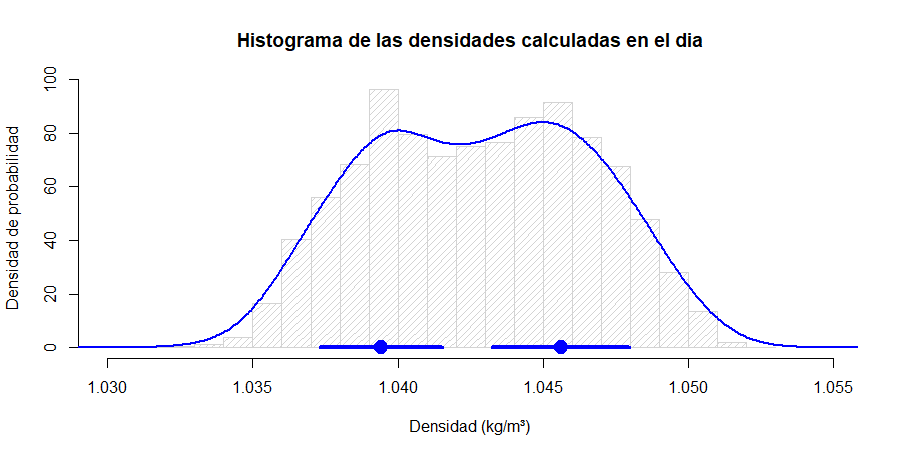

Por su parte, los resultados de los datos nocturnos para la densidad es:

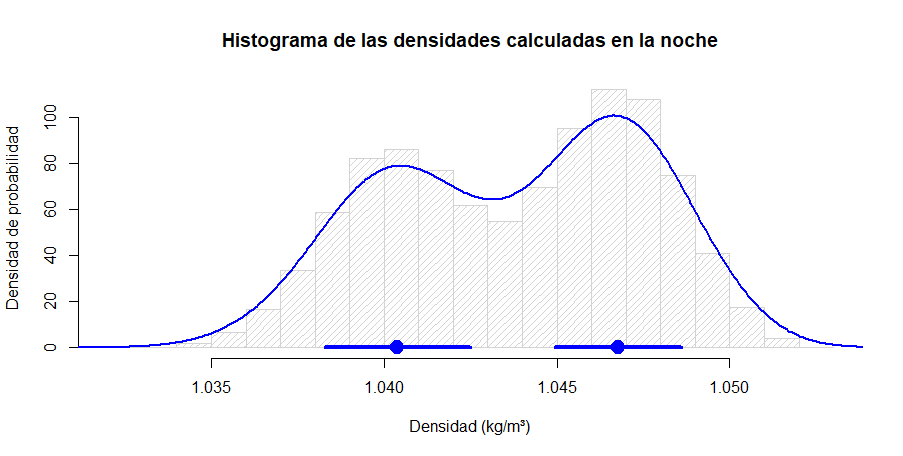

Finalmente, se realiza el análisis de incertidumbre asociada al cálculo de la densidad del aire.

In [ ]:
# Analisis de incertidumbre para la densidad del aire

#CALCULO DE INCERTIDUMBRES

#calculo de incertidumbre de la temperatura

uT=function(t){
  
  #Incertidumbre por resolución
  uT_Res = 0.01/sqrt(12)
  
  #Incertidumbre por gradiente de variación
  uT_Var = abs(max(t)-min(t))/sqrt(12)
  
  #Incertidumbre estándar de la temperatura
  uT = sqrt(uT_Res**2+uT_Var**2)
  
  return(uT)
}

#calculo de incertidumbre de la humedad relativa

uHR=function(hr){
  
  #Incertidumbre por resolución
  uHR_Res = 0.01/sqrt(12)
  
  #Incertidumbre por gradiente de variación
  uHR_Var = abs(max(hr)-min(hr))/sqrt(12)
  
  #Incertidumbre estándar de la humedad relativa
  uHR = sqrt(uHR_Res**2+uHR_Var**2)
  
  return(uHR)
}

#Calculo de incertidumbre de la presión

uP=function(p){
  
  #Incertidumbre por resolución
  uP_Res = 0.1/sqrt(12)
  
  #Incertidumbre por gradiente de variación
  uP_Var = abs(max(p)-min(p))/sqrt(12)
  
  #Incertidumbre estándar de la presión
  uP = sqrt(uP_Res**2+uP_Var**2)
  
  return(uP)
}

urho_a = function(tt,hh,pp,densidad){
  
  hh = hh/100
  pp = pp*100
  
  t_prom = mean(tt)
  hr_prom = mean(hh)
  p_prom = mean(pp)
  
  #Para f
  
  beta = 3.14*10**(-8) #Unidades: Pa^-1
  gamma = 5.6*10**(-7) #Unidades: K^-2 
  
  dfdP = beta
  dfdT = 2*gamma*t_prom
  
  uf = sqrt((dfdP*uP(pp))**2+(dfdT*uT(tt))**2)
  
  #Para Psv
  
  A = 1.2378847*10**(-5) #Unidades: K^{-2}
  B = -1.9121316*10**(-2) #Unidades: K^{-1}
  C = 33.93711047 #Unidades: Adimensional
  D = -6.3431645*10**3 #Unidades: K
  
  dPsvdT = 100*exp(A*(t_prom+273.15)**2+B*(t_prom+273.15)+C+D/(t_prom+273.15))*(2*A*(t_prom+273.15)+B-D/(t_prom+273.15)**2)
  
  uPsv = dPsvdT*uT(tt)
  
  #Para xv
  
  dxvdh = f(t_prom,p_prom)*Psv(t_prom)/p_prom
  dxvdf = hr_prom*Psv(t_prom)/p_prom
  dxvdPsv = hr_prom*f(t_prom,p_prom)/p_prom
  dxvdP = -hr_prom*f(t_prom,p_prom)*Psv(t_prom)/p_prom**2
  
  uxv = sqrt((dxvdh*uHR(hh))**2+(dxvdf*uf)**2+(dxvdPsv*uPsv)**2+(dxvdP*uP(pp))**2)
  
  #Para Z
  
  # Definición de constantes
  a0= 1.58123*10**(-6) #Unidades: K*Pa^-1
  a1= -2.9331*10**(-8) #Unidades: Pa^-1
  a2= 1.10432*10**(-10) #Unidades: K^-1*Pa^-1
  b0= 5.707*10**(-6) #Unidades: K*Pa^-1
  b1= -2.051*10**(-8) #Unidades: Pa^-1
  c0= 1.9898*10**(-4) #Unidades: K*Pa^-1
  c1= -2.376*10**(-6) #Unidades: Pa^-2
  d= 1.82*10**(-11) #Unidades: K^2*a^-2
  e= -0.765*10**(-8) #Unidades: K^2*Pa^-2
  
  T = (t_prom + 273.15)
  
  dZdP = -1/T*(a0 + a1*T + a2*T**2+(b0+b1*T)*xv(t_prom,p_prom,hr_prom)+(c0+c1*T)*xv(t_prom,p_prom,hr_prom)**2)+2*p_prom*(d+e*xv(t_prom,p_prom,hr_prom)**2)/T**2
  dZdxv = -p_prom/T*((b0+b1*T)+2*(c0+c1*T)*xv(t_prom,p_prom,hr_prom))+2*p_prom**2*e*xv(t_prom,p_prom,hr_prom)/T**2
  dZdt = p_prom/T**2*(a0 + a1*T + a2*T**2+(b0+b1*T)*xv(t_prom,p_prom,hr_prom)+(c0+c1*T)*xv(t_prom,p_prom,hr_prom)**2)-p_prom/T*(a1+2*a2*T+b1*xv(t_prom,p_prom,hr_prom)+c1*xv(t_prom,p_prom,hr_prom)**2) -2*p_prom**2*(d+e*xv(t_prom,p_prom,hr_prom)**2)/T**3
  
  uZ = sqrt((dZdP*uP(pp))**2+(dZdxv*uxv)**2+(dZdt*uT(tt))**2)
  
  #Para rho
  
  #Definición de constantes
  Ma= 28.96546*10**(-3) #kg mol^-1 
  Mv= 18.01527*10**(-3) #kg mol^-1
  R= 8.314472 #J*k*mol 
  
  drhodP = Ma*(1-xv(t_prom,p_prom,hr_prom)*(1-Mv/Ma))/(Z(t_prom,p_prom,hr_prom)*R*T)
  drhodZ = -p_prom*Ma*(1-xv(t_prom,p_prom,hr_prom)*(1-Mv/Ma))/(Z(t_prom,p_prom,hr_prom)**2*R*T)
  drhodT = -p_prom*Ma*(1-xv(t_prom,p_prom,hr_prom)*(1-Mv/Ma))/(Z(t_prom,p_prom,hr_prom)*R*T**2)
  drhodxv = p_prom*Ma*(1-Mv/Ma)/(Z(t_prom,p_prom,hr_prom)*R*T)
  
  #Incertidumbre por repetibilidad
  
  urep = sd(densidad)/sqrt(length(densidad))
  
  #Incertidumbre por ecuación
  
  uec = mean(densidad)*10**(-4)
  
  urho = sqrt((drhodP*uP(pp))**2+(drhodZ*uZ)**2+(drhodT*uT(tt))**2+(drhodxv*uxv)**2+urep**2+uec**2)
  
  return(urho)
}


Para el cálculo de incertidumbres y coeficientes de sensibilidad se tiene que:

***Para f:***

Si: $$f=\alpha + \beta \cdot P + \gamma\cdot t^2$$

Para la incertidumbre: 
$$u(f)=\sqrt{\left(\frac{\partial f}{\partial P}\cdot u(P)\right)^2+\left(\frac{\partial f}{\partial T}u(T)\right)^2}$$ \\


Para los coeficientes de sensibilidad:
$$\frac{\partial f}{\partial P}=\beta\left[\text{Pa}^{-1}\right]$$ \\
$$\frac{\partial f}{\partial t}=2\cdot \gamma\cdot t \left[\text{K}^{-1}\right]$$ \\


***Para $P_{sv}$ :*** 

Si: $$1\text{ Pa}\cdot e^{\left(A(t+273.15)^2+B(t+273.15)+\frac{D}{t+273.15}\right)}$$

Para la incertidumbre:

$$u(P_{sv})=\frac{\partial P_{sv}}{\partial t}\cdot u(t)$$ \\


Para el coeficiente de sensibilidad: 
$$\frac{\partial P_{sv}}{\partial t}=(1 \text{ Pa})\cdot e^{\left(A(t+273.15)^2+B(t+273.15)+\frac{D}{t+273.15}\right)}\cdot \left[2 A(t+273.15)+B-\frac{D}{(t+273.15)^2}\right]\left[\frac{\text{kg}\cdot \text{K}^{-1}}{\text{m}\cdot \text{s}^2}\right]$$ 

***Para $x_{\nu}$ :***

Si: $$x_{\nu}=h\cdot f\cdot \frac{P_{sv}}{P}$$

Para la incertidumbre:

$$u(x_{\nu})=\sqrt{\left(\frac{\partial x_{\nu}}{\partial h}\cdot u(h)\right)^2+\left(\frac{\partial x_{\nu}}{\partial f}\cdot u(f)\right)^2+\left(\frac{\partial x_{\nu}}{\partial P_{sv}}\cdot u(P_{sv})\right)^2 +\left(\frac{\partial x_{\nu}}{\partial P}\cdot u(P)\right)^2  }$$ \\

Para los coeficientes de sensibilidad:
$$\frac{\partial x_{\nu}}{h}=f\cdot \frac{P_{sv}}{P}\left[\text{adimensional}\right]$$ \\
$$\frac{\partial x_{\nu}}{f}=h\cdot \frac{P_{sv}}{P}\left[\text{adimensional}\right]$$

*Para Z :* \\ **texto en negrita**

Si: $$Z=1-\frac{P}{t+273.15}\left[a_0+a_1t+a_2t^2+(b_0+b_1t)x_{\nu}+(c_0+c_1t)x_{\nu}^2\right]+\frac{P^2}{(t+273.15)^2}\cdot (d+e\cdot x_{\mu}^2)$$

Para la incertidumbre:
$$u(z)=\sqrt{\left(\frac{\partial Z}{\partial P}\cdot u(P)\right)^2+\left(\frac{\partial Z}{\partial t}\cdot u(t)\right)^2+\left(\frac{\partial Z}{\partial x_{\nu}}\cdot u(x_{\nu})\right)^2}$$ \\

Para los coeficientes de sensibilidad:

$$\frac{\partial Z}{\partial P}=-\frac{1}{t+273.15}\left[a_0+a_1t+a_2t^2+(b_0+b_1t)x_{\nu}+(c_0+c_1t)x_{\nu}^2\right]+\frac{2P}{(t+273.15)^2}\cdot (d+e\cdot x_{\mu}^2) \left[\text{Pa}^{-1}\right]$$ \\

$$\frac{\partial Z}{\partial x_{\nu}}=\frac{-P}{t+273.15}[(b_0+b_1 t)+2(c_0+c_1 t)x_{\nu}]+\frac{2\cdot P^2 \cdot x_{\nu}}{(t+273.15)} [\text{adimensional}]$$ \\


$$\frac{\partial Z}{\partial t} = \frac{P}{(t+273,15)^2} \left[ a_0 + a_1 \cdot t + a_2 \cdot t^2 + (b_0 +b_1 \cdot t) \cdot X_\nu + (C_0 +C_1 \cdot t)\cdot X_{\nu^2}  \right] - \frac{P}{t+273,15} \cdot  \left[ a_1 + 2a_2 +b_1 \cdot X_nu + C_1 \cdot X_\nu ^2 \right] -2\cdot \frac{P^2}{(t+273,15)^3} \cdot (d+e \cdot X_\nu ^2  )  $$


***Finalmente para $\rho_a$ :***

Si: 

$$\rho_a=\frac{P \cdot M_a}{Z \cdot R \cdot (t+273,15)} \left[ 1- x_\nu (1- \left(\frac{M_\nu}{M_a}\right) \right] $$ \\


Para la incertidumbre:

$$u(\rho_a)=\sqrt{  \left( \frac{\partial \rho_a }{\partial P} u(P) \right)^2 + \left( \frac{\partial \rho_a }{\partial Z} u(Z) \right)^2 + \left( \frac{\partial \rho_a }{\partial t} u(t) \right)^2 + \left( \frac{\partial \rho_a }{\partial x_\nu} u(x_\nu) \right)^2 +u_{ec}^2 (\rho_a) + u_{rep}^2 (\rho_a)  }  $$ \\



Para los coeficientes de sensibilidad:

$$\frac{\partial \rho_a}{\partial P}= \frac{M_a}{Z \cdot R \cdot (t+273,15)} \left[ 1- x_\nu (1- \left(\frac{M_\nu}{M_a}\right) \right] \left[\frac{\text{K}\cdot \text{s}^2}{\text{kg}\cdot \text{m}^2}\right]$$ \\


$$ \frac{\partial \rho_a}{\partial z}=  \frac{-P \cdot M_a}{Z^2 \cdot R \cdot (t+273,15)} \left[ 1- x_\nu (1- \left(\frac{M_\nu}{M_a}\right) \right] \left[\frac{\text{kg}}{\text{m}^3}\right]$$ \\


$$\frac{\partial \rho_a}{\partial t}=  \frac{-P \cdot M_a}{Z \cdot R \cdot (t+273,15)^2} \left[ 1- x_\nu (1- \left(\frac{M_\nu}{M_a}\right) \right] \left[\frac{\text{kg}}{\text{m}^3\cdot \text{K}}\right] $$ \\

$$\frac{\partial \rho_a}{\partial X_\nu}= \frac{-P \cdot M_a}{Z \cdot R \cdot (t+273,15)} \left[ 1-  \left(\frac{M_\nu}{M_a}\right) \right]   \left[\frac{\text{kg}}{\text{m}^3}\right]$$ \\

Dicha incertidumbre, se calcula con el siguiente código:

In [ ]:
#Densidad del aire de los datos diurnos
mean(densidad_diadf$`Densidad día`)

#Incertidumbre densidad del aire de los datos diurnos
urho_a(datos_totales_dia_limpio$Temperatura,datos_totales_dia_limpio$`Humedad Relativa`,datos_totales_dia_limpio$Presión,densidad_diadf$`Densidad día`)

#Densidad del aire de los datos nocturnos
mean(densidad_nochedf$`Densidad noche`)

#Incertidumbre dendidad del aire de los datos noctunos
urho_a(datos_totales_noche_limpio$Temperatura,datos_totales_noche_limpio$`Humedad Relativa`,datos_totales_noche_limpio$Presión,densidad_nochedf$`Densidad noche`)
